# RSM8413: Case 1

#### Team 15: Joanne Chien, Harsh Pinge, Venkata Surya Sai Nikhil Garimella, Sharon Xiao, Jitao Zhang

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt

from numpy import arange
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## 1. Cleaning the dataset

### 1.1 First glimpse of the dataset

In [206]:
ebay_raw = pd.read_excel("data/ebayAuctions.xlsx", sheet_name = "eBay auctions")
ebay_raw.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [207]:
ebay_raw.shape

(1972, 8)

In [208]:
ebay_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [209]:
ebay_raw.describe()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,36.449087,12.926268,0.540568
std,5973.011033,2.052906,89.493858,38.856149,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.907500,1.230000,0.000000
50%,1853.000000,7.000000,9.995000,4.500000,1.000000
75%,3380.000000,7.000000,28.000000,9.990000,1.000000
max,37727.000000,10.000000,999.000000,999.000000,1.000000


In [210]:
ebay_raw['Category'].value_counts()

Category
Music/Movie/Game        403
Collectibles            239
Toys/Hobbies            234
Automotive              178
Antique/Art/Craft       177
SportingGoods           124
Clothing/Accessories    119
Home/Garden             102
Jewelry                  82
Health/Beauty            64
Electronics              55
Books                    54
Coins/Stamps             37
Computer                 36
Pottery/Glass            20
Business/Industrial      18
EverythingElse           17
Photography              13
Name: count, dtype: int64

In [211]:
ebay_raw['Currency'].value_counts()

Currency
US     1292
EUR     533
GBP     147
Name: count, dtype: int64

In [212]:
ebay_raw['endDay'].value_counts()

endDay
Mon    548
Sat    351
Sun    338
Fri    287
Thu    202
Tue    171
Wed     75
Name: count, dtype: int64

### 1.2 Initial Cleanings

In [213]:
# Rename the response column and format all other variable names
ebay = ebay_raw.rename(columns={'Competitive?': 'Competitive',
                                'sellerRating': 'SellerRating',
                                'endDay': 'EndDay'})
ebay.head()

,Category,Currency,SellerRating,Duration,EndDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [214]:
# convert all prices into USD (preparation)
# https://www.xe.com/currencytables/?from=GBP&date=2004-12-31
# FX on May 31, 2004
eur_to_usd = 1.2076
gbp_to_usd = 1.8080

def convert_fx(row):
    if row['Currency'] == 'EUR':
        row['ClosePrice'] *= eur_to_usd
        row['OpenPrice'] *= eur_to_usd
    elif row['Currency'] == 'GBP':
        row['ClosePrice'] *= gbp_to_usd
        row['OpenPrice'] *= gbp_to_usd
    return row

In [215]:
# convert all prices into USD (continue) & get rid of the currency column
ebay = ebay.apply(convert_fx, axis = 1)
ebay['ClosePrice'] = ebay['ClosePrice'].round(2)
ebay['OpenPrice'] = ebay['OpenPrice'].round(2)

ebay = ebay.drop(columns=['Currency'])

In [216]:
ebay.tail(10)

,Category,SellerRating,Duration,EndDay,ClosePrice,OpenPrice,Competitive
1962,Automotive,0,10,Sun,590.00,99.00,1
1963,Automotive,4,10,Sun,943.00,148.50,1
1964,SportingGoods,1,7,Fri,417.99,200.00,1
1965,Automotive,97,3,Fri,290.00,290.00,0
1966,Automotive,142,7,Sat,521.55,200.00,1
1967,Automotive,2992,5,Sun,359.95,359.95,0
1968,Automotive,21,5,Sat,610.00,300.00,1
1969,Automotive,1400,5,Mon,549.00,549.00,0
1970,Automotive,57,7,Fri,820.00,650.00,1
1971,Automotive,145,7,Sat,999.00,999.00,0


In [217]:
ebay.describe()

,SellerRating,Duration,ClosePrice,OpenPrice,Competitive
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,39.405147,13.574544,0.540568
std,5973.011033,2.052906,95.610641,39.410893,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.990000,1.490000,0.000000
50%,1853.000000,7.000000,11.145000,4.990000,1.000000
75%,3380.000000,7.000000,30.960000,11.015000,1.000000
max,37727.000000,10.000000,1042.500000,999.000000,1.000000


## 2. EDA

### 2.1 Proportion of competitive in each category

In [218]:

category_counts = ebay.groupby(['Category', 'Competitive']).size().reset_index(name='count')
category_counts['total'] = category_counts.groupby('Category')['count'].transform('sum')
category_counts['proportion'] = category_counts['count'] / category_counts['total']

chart = alt.Chart(category_counts).mark_bar().encode(
    x = alt.X('Category:N', title = 'Category'),
    y = alt.Y('proportion:Q', title = 'Proportion'),
    color = alt.Color('Competitive:N', title = 'Competitive'),
    tooltip = alt.Tooltip('proportion:Q', title = 'Proportion')
).properties(
    title='Standardized Competitive Distribution by Category'
)

chart.show()

alt.Chart(...)

### 2.2 Facet plots of OpenPrice vs ClosePrice

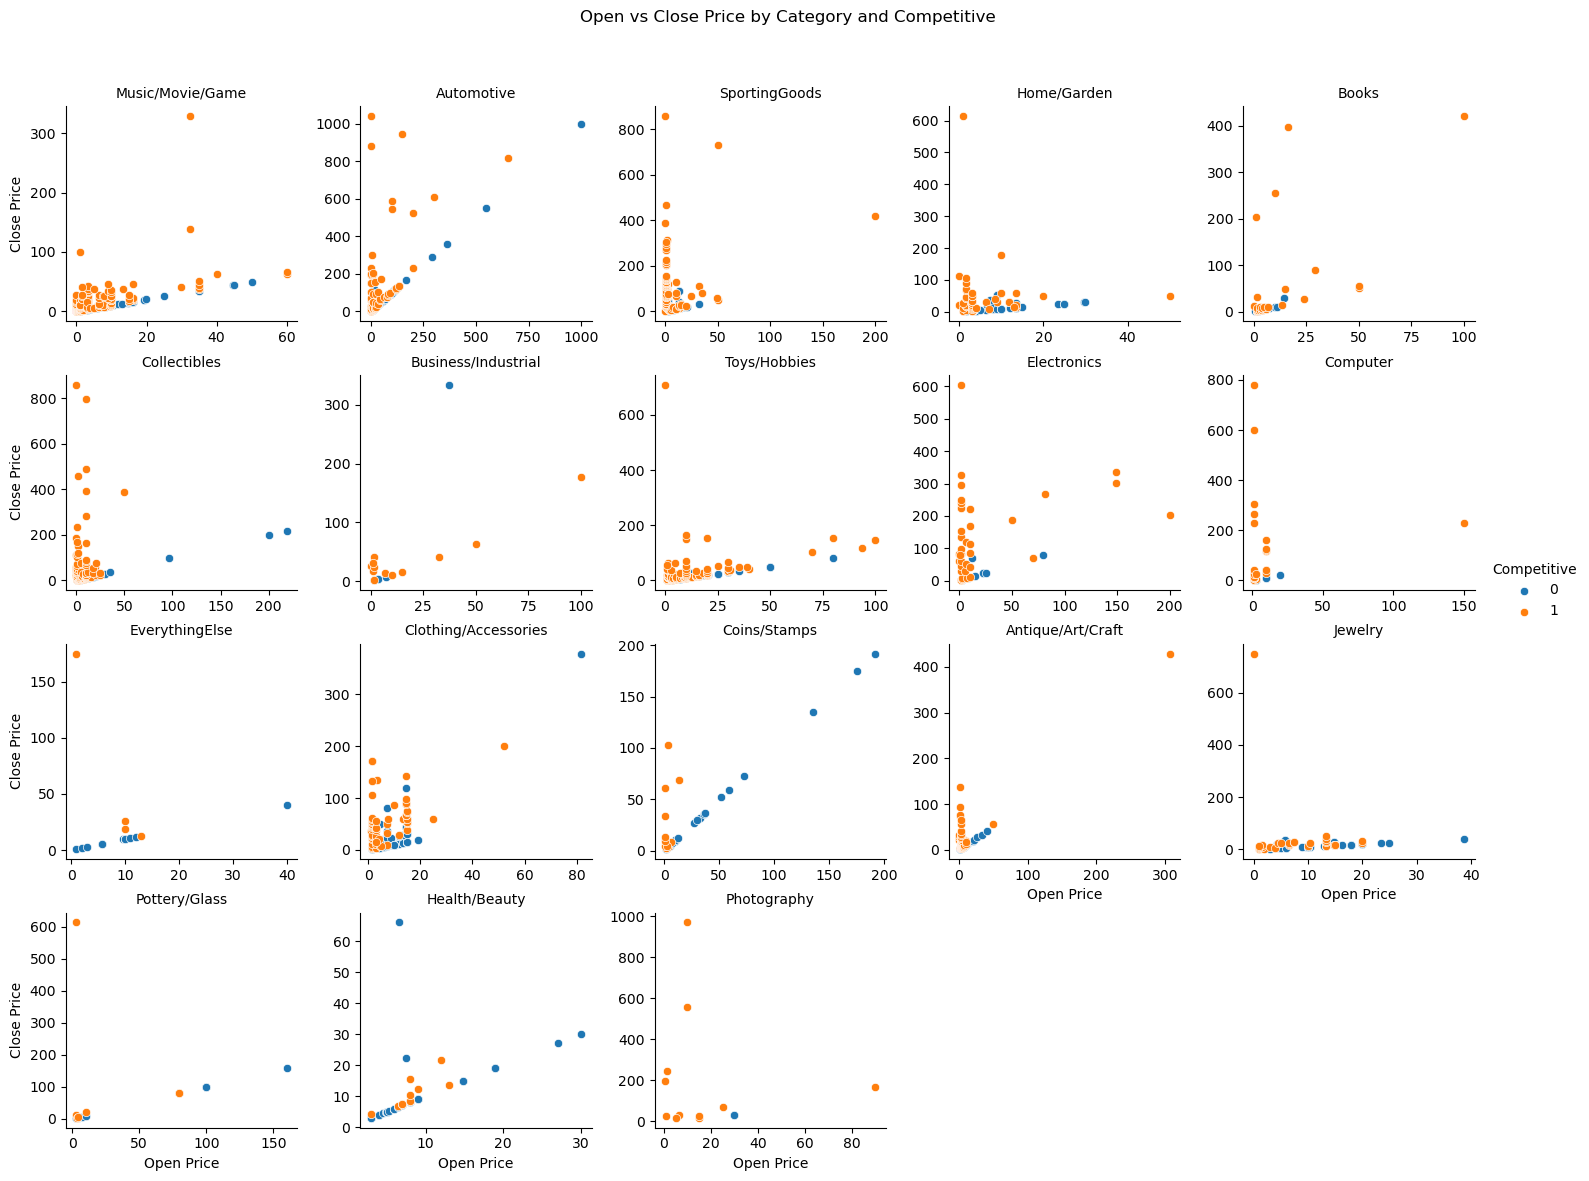

In [219]:
grid = sns.FacetGrid(
    ebay,
    col = 'Category',
    col_wrap = 5,               # 5 plots per row
    hue = 'Competitive',        # Color by competitive label
    height = 3,                 # Size of each subplot
    sharex = False,
    sharey = False
)

grid.map_dataframe(sns.scatterplot, x = 'OpenPrice', y = 'ClosePrice')
grid.add_legend(title = 'Competitive')
grid.set_axis_labels('Open Price', 'Close Price')
grid.set_titles(col_template = '{col_name}')

plt.subplots_adjust(top = 0.9)
plt.suptitle('Open vs Close Price by Category and Competitive')

plt.show()

## 3. Other Set-ups before fitting the models

### 3.1 Set up the scoring metric and folds that will be used for CV

In [220]:
# accuracy will be our chosen accuracy throughout this project
scoring_metric = "accuracy"

# folds that we will be using for CV
kfold = 10

### 3.2 Spliting the data

In [221]:
train_df, test_df = train_test_split(ebay, test_size = 0.4, random_state = 8413)

X_train = train_df.drop(columns = ['Competitive'])
y_train = train_df['Competitive']
X_test = test_df.drop(columns = ['Competitive'])
y_test = test_df['Competitive']

print(X_train.shape)
print(X_test.shape)

(1183, 6)
(789, 6)


### 3.3 Building Data Cleaning Preprocessor 

In [222]:
numeric_features = ["SellerRating",
                    "Duration",
                    "ClosePrice",
                    "OpenPrice"]
categorical_features = ["Category",
                        "EndDay"]


In [223]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output = False)

In [224]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

preprocessor

,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 4. KNN

In [225]:
X_transformed = preprocessor.fit_transform(X_train)
# then follow what is done in class

## 5. Decision Tree

### 5.1 Decision Tree first half

#### Step 1: Tunning the hyper-parameter for decision tree

In [226]:
pipe_dt_tune = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(min_samples_leaf = 50, random_state = 8413)
)

param_grid = {
    "decisiontreeclassifier__max_depth": [1, 3, 5, 7, 10]
}

gs_dt = GridSearchCV(
    pipe_dt_tune,
    param_grid = param_grid,
    n_jobs = -1,
    scoring = scoring_metric,
    cv = kfold
)

gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_)
print("Best accuracy:", gs_dt.best_score_)

{'decisiontreeclassifier__max_depth': 5}
Best accuracy: 0.8139581256231306


#### Step 2: Fit the tree with the optimal tuned hyper-parameter

In [227]:
pipe_dt_best = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 50, random_state = 8413))
pipe_dt_best.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


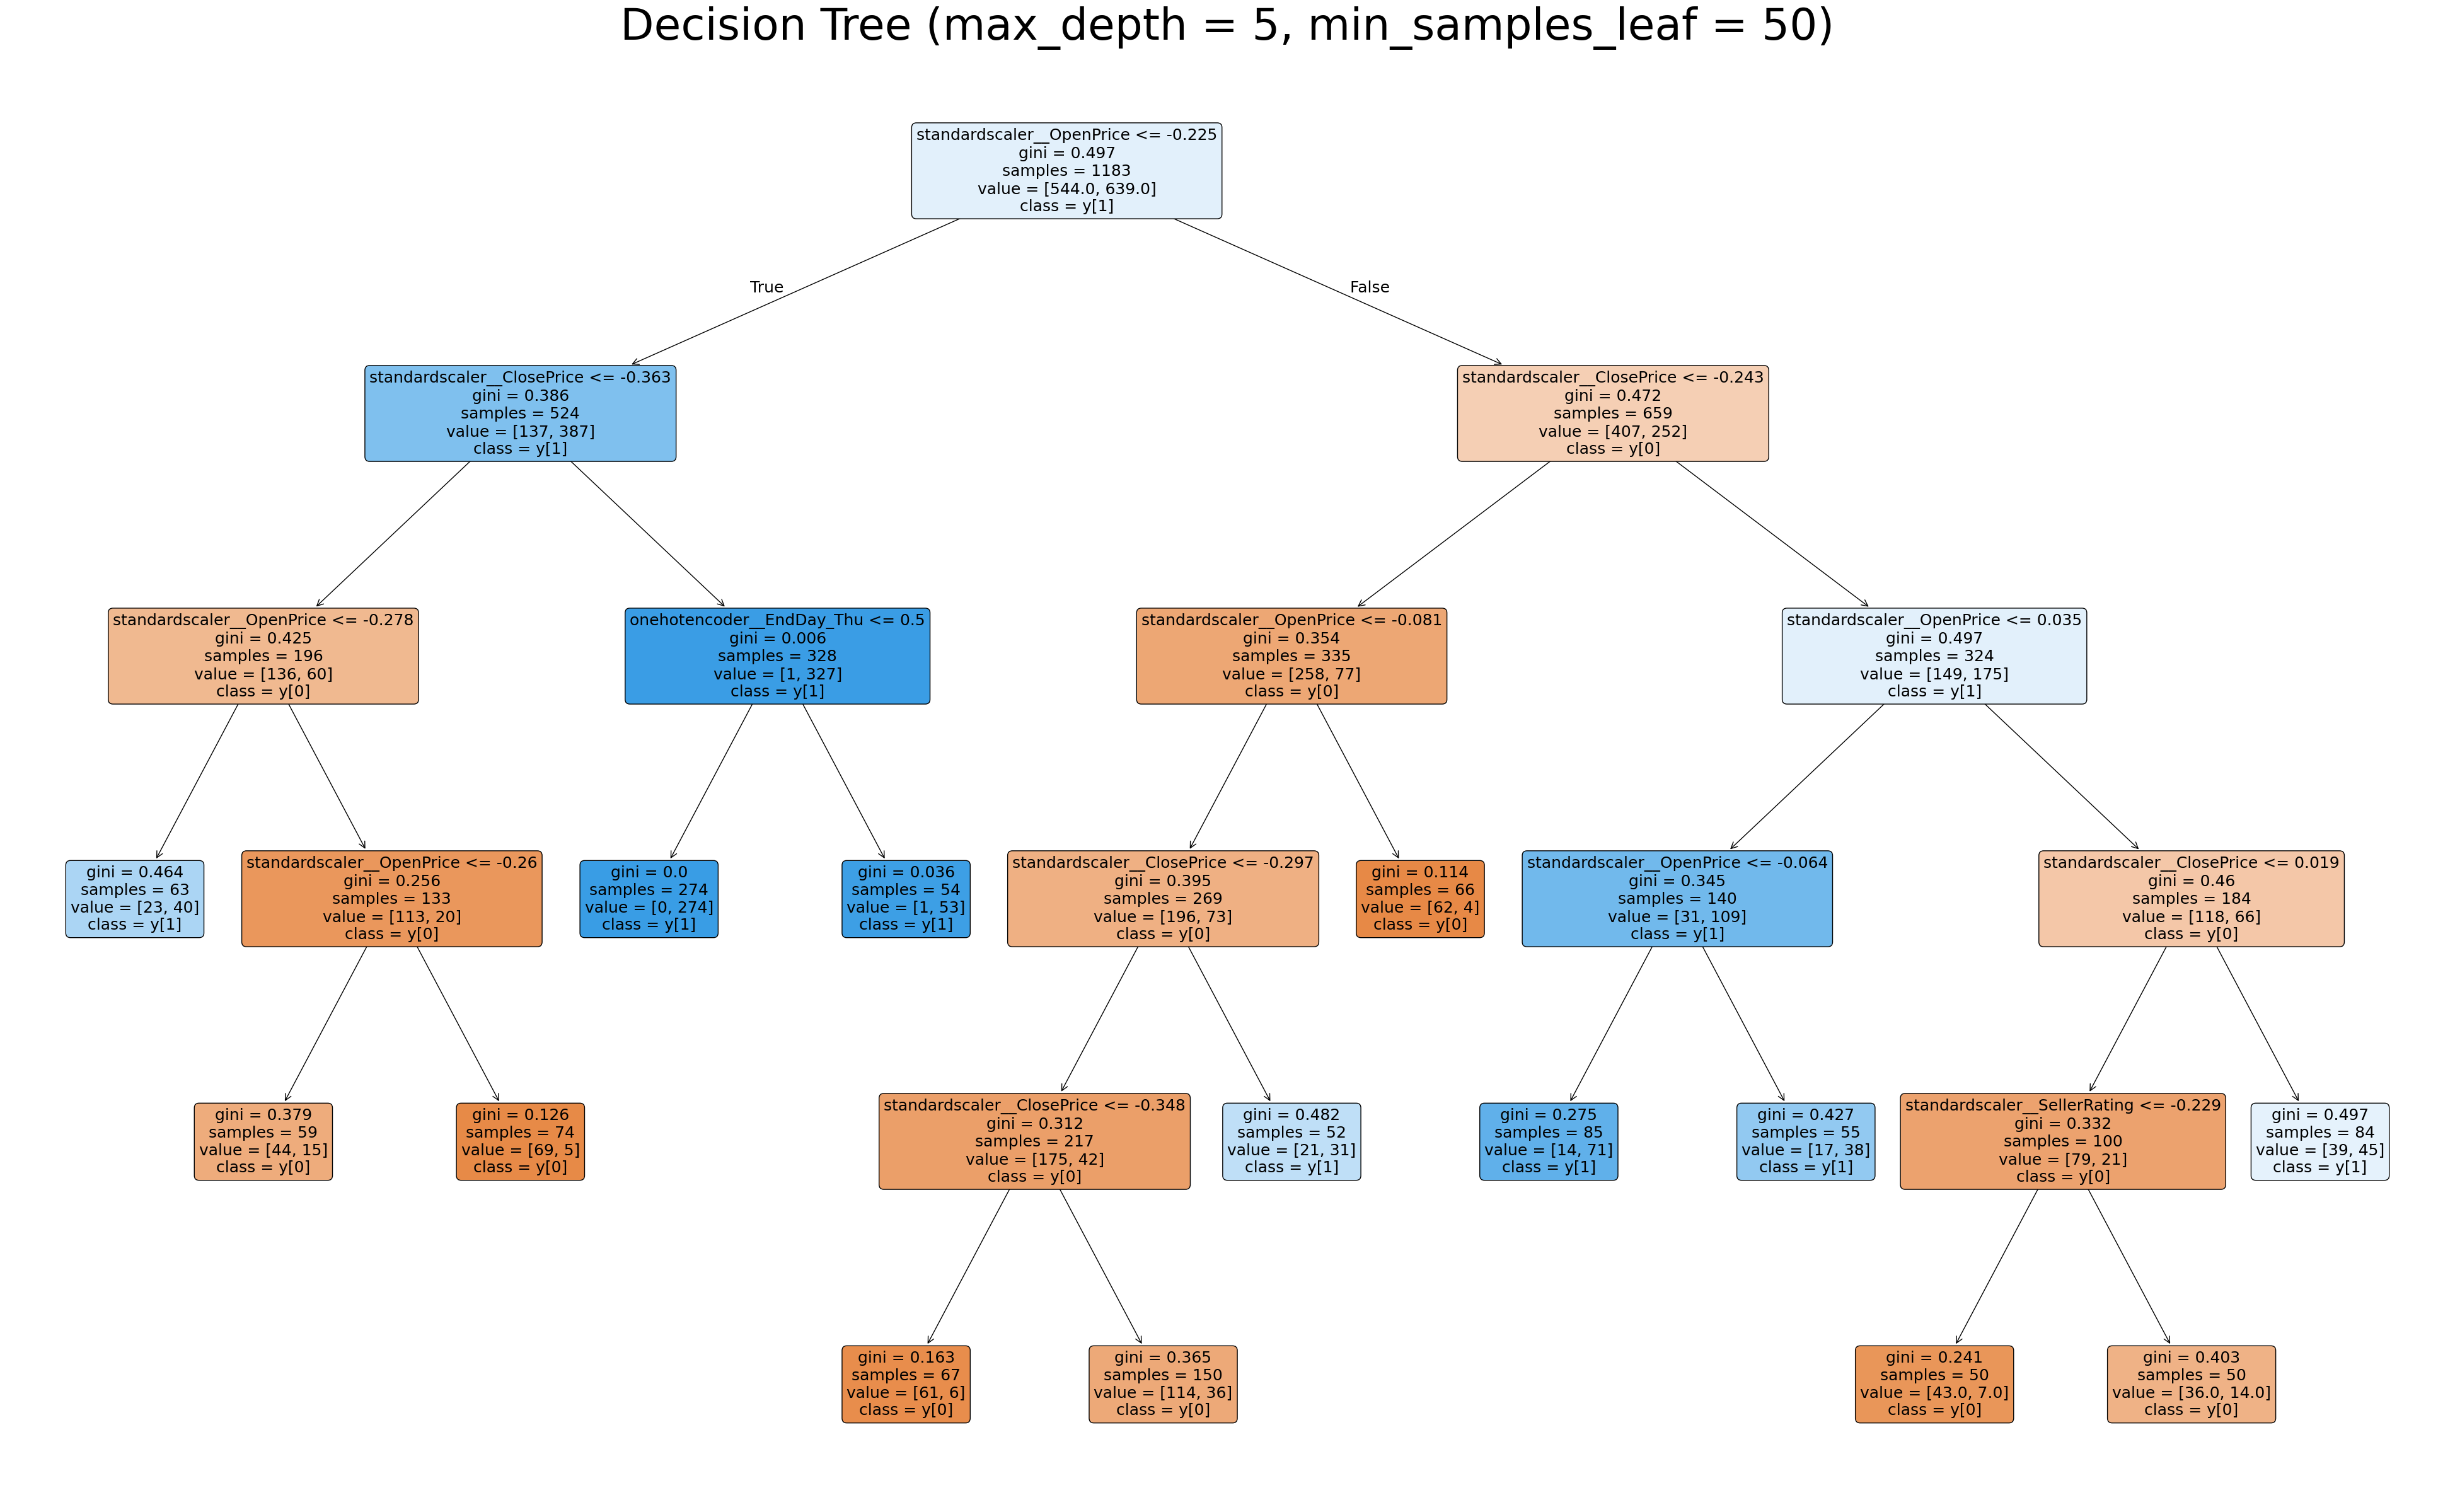

In [228]:
dt_model_best = pipe_dt_best.named_steps['decisiontreeclassifier']

plt.figure(figsize = (50, 30))  
plot_tree(
    dt_model_best,
    filled = True,
    feature_names = preprocessor.get_feature_names_out(),
    class_names = True,  
    rounded = True,
    fontsize = 18
)
plt.title("Decision Tree (max_depth = 5, min_samples_leaf = 50)", fontsize = 50)
plt.show()

#### Step 3: Results on the test set

In [229]:
test_score = pipe_dt_best.score(X_test, y_test)    # score: use accuracy as the default metric
print("Accuracy of decision tree on the test set:", test_score)

Accuracy of decision tree on the test set: 0.8048162230671736


explanation required: talk about my entire workflow. point out any splits that are intuitive and any splits that are not.

In [230]:
# decide which variables can be removed
importances = dt_model_best.feature_importances_

feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.tail(10))  # least 10 important features

                                         feature  importance
12           onehotencoder__Category_Electronics         0.0
11              onehotencoder__Category_Computer         0.0
10          onehotencoder__Category_Collectibles         0.0
9           onehotencoder__Category_Coins/Stamps         0.0
8   onehotencoder__Category_Clothing/Accessories         0.0
7    onehotencoder__Category_Business/Industrial         0.0
6                  onehotencoder__Category_Books         0.0
5             onehotencoder__Category_Automotive         0.0
4      onehotencoder__Category_Antique/Art/Craft         0.0
28                     onehotencoder__EndDay_Wed         0.0


so remove EndDay for sure in next step => also intuitive

but do not remove cateogry because it doesn't cater to our intuition, a better way to deal with category is through feature engineering (fuse some levels in Category together since there are too many of them right now and there is a high chance that there is some correlation between some of those levels) in furture studies!

is this model practical in real life? probably not because we won't know features like endprice before the auction ends (feature availability)

on the other hand, test accuracy & speed/interpretability & other features availability => is bonus to use this model in real life

who will be using this model? sellers? buyers? platforms? This model could assist sellers in adjusting their starting prices or item descriptions based on predicted outcomes, improving success rates and platform satisfaction. (It could provide valuable insights to sellers and the platform by estimating the likelihood of a successful auction, helping with listing strategies and risk mitigation.)